# Laboratorio: Regressione

## Analisi di Regressione

- Un _modello di regressione_ permette di ottenere una stima $\hat{y}$ del valore $y$ di una variabile _dipendente_ in base ad una o più variabili _indipendenti_ $x_1,\ldots,x_n$
- Viene addestrato su osservazioni di cui si conoscono i valori sia delle variabili indipendenti che di $y$, in modo da minimizzare l'errore che compie su queste osservazioni
- Una volta addestrato, il modello può essere usato per effettuare stime su nuovi dati e predizioni sul futuro
- La regressione _lineare_ è un modello semplice ma spesso abbastanza efficace per ricavare modelli di predizione
- Possiamo implementare la regressione lineare tramite _discesa gradiente_ con semplici operazioni tra vettori

In [1]:
import numpy as np
import pandas as pd

## Caso di Studio 1: Predizione del Consumo di Elettricità

- Per dimensionare adeguatamente le risorse, una compagnia elettrica deve predire giornalmente quanta corrente sarà consumata il giorno dopo
- Si ipotizza che nei mesi estivi una quota consistente di energia sia impiegata per l'aria condizionata
- La compagnia incrocia quindi i dati storici sul consumo con quelli sulla temperatura per indagare sul fenomeno...

## Caricamento dei Dati

- Prendiamo come esempio i dati relativi all'area di Pittsburgh negli USA
  - la compagnia elettrica rende disponibili dati storici sul consumo quì: http://www.pjm.com/markets-and-operations/ops-analysis/historical-load-data.aspx
  - i dati sulle temperature registrate possono invece essere reperiti da quì: http://wefacts.org/
- Abbiamo raccolto i dati utili dal 2015 al 2017 in un file CSV con colonne _data_, _temperatura media_, _picco di consumo_
- Usiamo pandas per caricare i dati in un DataFrame dato l'URL del file
  - col parametro `parse_dates` si può indicare a pandas di interpretare i valori di colonne indicate come date

In [2]:
data = pd.read_csv("https://git.io/vpaM1", parse_dates=["date"])

In [3]:
data.head(10)

,date,demand,temp
0,2015-01-01,1.736065,1.7
1,2015-01-02,1.831672,2.2
2,2015-01-03,1.714934,14.4
3,2015-01-04,1.628577,15.6
4,2015-01-05,2.045394,0.0
5,2015-01-06,2.122799,-6.7
6,2015-01-07,2.243265,-9.4
7,2015-01-08,2.240975,-8.9
8,2015-01-09,2.128072,-6.1
9,2015-01-10,1.979734,-8.9


- Per iniziare, vediamo come visualizzare i dati in un grafico...

## matplotlib

- _matplotlib_ è la libreria Python più diffusa per la generazione di grafici sui dati
  - può generare grafici a barre, a linea, a torta, ...
- Usiamo matplotlib per generare semplici grafici per rappresentare i dati su cui lavoriamo
- Il modo più comune di usare matplotlib è tramite l'interfaccia _pyplot_, convenzionalmente importata come `plt`

In [4]:
import matplotlib.pyplot as plt

- Una volta generati, i grafici sono mostrati in una finestra con l'istruzione `plt.show()`
  - in alternativa si possono salvare su file con vari formati (PNG, SVG, PDF, ...)
- In Jupyter, è possibile abilitare l'inseririmento dei grafici generati direttamente nel documento usando il seguente "comando magico":

In [5]:
%matplotlib inline

## Grafico a Dispersione

- Un _grafico a dispersione_ (_scatter plot_) mostra un insieme di osservazioni come punti su un piano, le cui coordinate di ciascuno riflettono i valori di due variabili
- È utilizzabile per avere un'informazione visiva del grado di correlazione tra due variabili dato un insieme di campioni
- Per creare un grafico a dispersione con _N_ punti si usa la funzione `scatter` passando due vettori di _N_ valori con le coordinate X e Y rispettivamente
  - un "vettore" può consistere in una lista, un array NumPy, una serie pandas, ...

![Grafico a dispersione](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/OLS_example_weight_vs_height_scatterplot.svg/500px-OLS_example_weight_vs_height_scatterplot.svg.png)

- Visualizziamo i dati caricati come punti le cui coordinate X indichino la temperatura registrata e le Y il picco di consumo raggiunto nello stesso giorno

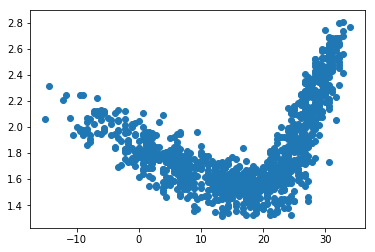

In [6]:
plt.scatter(data.temp, data.demand)

### Aggiunta di Etichette al Grafico

- Dopo l'istruzione per creare il grafico, possiamo eseguirne altre per aggiungere un titolo e le etichette degli assi...

Text(0,0.5,'Peak demand (GW)')

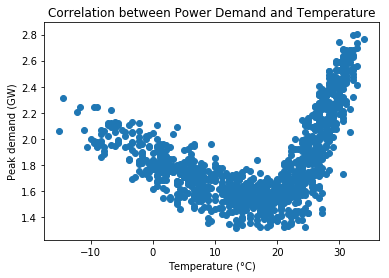

In [7]:
plt.scatter(data.temp, data.demand)
plt.title("Correlation between Power Demand and Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Peak demand (GW)")

### Creare Grafici tramite pandas

- Le strutture dati di pandas offrono proprie funzioni per creare rapidamente grafici che rappresentino i dati in esse
- Possiamo ad esempio creare un grafico a dispersione di due colonne di un DataFrame indicandone semplicemente il nome...

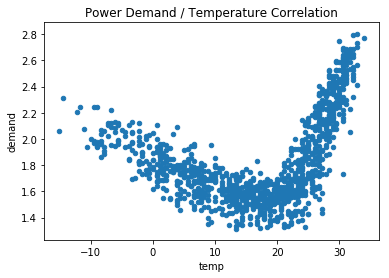

In [8]:
data.plot.scatter("temp", "demand",
                  title="Power Demand / Temperature Correlation")

## Selezione dei Dati

- Vogliamo analizzare la correlazione tra consumi e temperature specificamente nei mesi estivi
- Selezioniamo quindi dai dati solamente le osservazioni relative ai mesi di giugno, luglio e agosto di ciascun anno
- Le serie di tipo data/ora offrono un attributo `dt` con operazioni elemento per elemento per estrarre componenti specifici (es. giorno, minuto, ...)
- Ad es. per ottenere una serie che indica il mese di ciascuna riga...

In [9]:
data.date.dt.month   .head()

0    1
1    1
2    1
3    1
4    1
Name: date, dtype: int64

- Possiamo quindi selezionare le righe il cui mese è uno dei tre estivi
  - `x.between(a, b)` equivale a `(x >= a) & (x <= b)`

In [10]:
data_summer = data.loc[data.date.dt.month.between(6, 8)]

In [11]:
data_summer.head(10)

,date,demand,temp
151,2015-06-01,1.640036,15.6
152,2015-06-02,1.663211,17.2
153,2015-06-03,1.728381,21.7
154,2015-06-04,1.921615,25.0
155,2015-06-05,2.153111,27.8
156,2015-06-06,1.717011,23.9
157,2015-06-07,1.936838,28.9
158,2015-06-08,2.202273,26.1
159,2015-06-09,1.967314,23.9
160,2015-06-10,2.381218,30.0


- Visualizziamo un grafico a dispersione con i soli dati selezionati

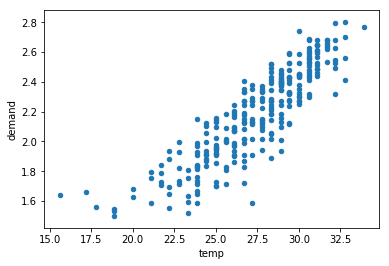

In [12]:
data_summer.plot.scatter("temp", "demand")

- Il grafico suggerisce che esiste una correlazione tra temperatura e consumo di corrente nei mesi estivi

## Regressione Lineare Univariata

- Con i dati disponibili, possiamo creare un modello di regressione per stimare il consumo di corrente $y$ in base alla temperatura prevista $x$
- La regressione lineare univariata genera un modello con due parametri $\alpha$ e $\beta$
$$ \hat{y} = h(x) = \alpha\cdot x+\beta $$
- Per determinati valori per i parametri, l'errore compiuto dal modello sui dati disponibili è spesso quantificato dalla _media degli errori quadrati_
$$ E(\alpha,\beta)=\frac{1}{m}\sum_{j=1}^m\left(h(x_j)-y_j\right)^2=\frac{1}{m}\sum_{j=1}^m\left(\alpha\cdot x_j+\beta-y_j\right)^2 $$
- L'obiettivo è trovare i valori di $\alpha$ e $\beta$ che minimizzino questa quantità

## Discesa del Gradiente

- Il _gradiente_ di una funzione indica in pratica la direzione in cui la curva della funzione stessa è maggiormente "inclinata"
  - il gradiente è il vettore delle _derivate parziali_ per ogni variabile
- Ad esempio il gradiente della funzione errore riportata sopra è dato da:
$$ \nabla E(\alpha,\beta)=\left(\frac{\delta E}{\delta\alpha},\frac{\delta E}{\delta\beta}\right) $$
$$ =\left(\quad\frac{2}{m}\sum_{j=1}^m(\alpha\cdot x_j+\beta-y_j)\cdot x_j,\quad\frac{2}{m}\sum_{j=1}^m(\alpha\cdot x_j+\beta-y_j)\quad\right) $$
- L'algoritmo di _discesa del gradiente_, partendo da valori arbitrari di $\alpha$ e $\beta$, segue progressivamente il gradiente di $E$ per trovarne il minimo
- Fissata una lunghezza del passo $\eta$, ad ogni passaggio $\alpha$ e $\beta$ sono iterativamente aggiornati come segue:
$$ \alpha\leftarrow\alpha-\eta\cdot\frac{\delta E}{\delta\alpha} \qquad \beta\leftarrow\beta-\eta\cdot\frac{\delta E}{\delta\beta} $$
- In termini vettoriali, ponendo $\theta=(\alpha,\beta)$:
$$ \theta\leftarrow\theta-\eta\cdot\nabla E(\theta) $$

### Algoritmo

- La seguente funzione implementa la discesa del gradiente per un problema di regressione lineare univariata
  - i vettori `x` e `y` contengono _m_ osservazioni rispettivamente della variabile _indipendente_ (temperatura) e _dipendente_ (consumo)
  - i parametri $\alpha$ e $\beta$ sono inizializzati a 0
  - per un numero _N_ di iterazioni prefissato si calcolano
    1. il vettore `error` con le differenze tra valore reale e predetto di $y$ per ogni osservazione
    2. le derivate parziali dell'errore rispetto ad $\alpha$ e $\beta$
    3. i nuovi valori di $\alpha$ e $\beta$
  - i valori dei parametri dopo l'ultima iterazione sono restituiti

In [13]:
def uni_lin_reg_gd(x, y, N=50, step_size=0.001):
    alpha, beta = 0, 0
    for it in range(N):
        error = alpha * x + beta - y
        d_alpha = 2 * (error * x).mean()
        d_beta = 2 * error.mean()
        alpha -= step_size * d_alpha
        beta -= step_size * d_beta
    return alpha, beta

## Visualizzazione della Retta di Regressione

- Per vedere ad occhio come il modello di regressione approssimi i dati reali, è possibile tracciare la retta definita dal modello nel grafico a dispersione
- Definiamo una funzione che, dati i valori di $\alpha$ e $\beta$, disegni il grafico con la retta corrispondente ai parametri
  - al grafico a dispersione viene sovrapposto un grafico a linea che unisce due punti, le cui coordinate X corrispondono ai bordi del grafico e le rispettive coordinate Y sono calcolate dal modello

In [14]:
def plot_reg_line(x, y, alpha, beta):
    # disegno il grafico a dispersione come visto sopra
    plt.scatter(x, y)
    # matplotlib ha impostato in automatico gli intervalli X e Y del grafico
    # li estraggo in forma di due tuple (Xmin, Xmax) e (Ymin, Ymax)
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    # definisco le coordinate dei due punti estremi della linea da tracciare
    # le coordinate X sono i limiti dell'asse X del grafico
    line_x = np.array(xlim)
    # col modello di regressione calcolo le corrispondenti coordinate Y
    line_y = alpha * line_x + beta
    # traccio la linea sovrapposta al grafico a dispersione già tracciato
    plt.plot(line_x, line_y, c="red", lw=3)   # c = colore, lw = spessore
    # i limiti del grafico sono ricalcolati sulla linea: li reimposto
    plt.xlim(xlim)
    plt.ylim(ylim)

## Esempio di Modello

- Si ipotizzi ad esempio di impostare arbitrariamente i parametri a $\alpha=0.2,\beta=-3$
- La funzione che approssima il consumo in base alla temperatura $x$ sarebbe $h(x)=0.2\cdot x-3$
- Ad es. per una temperatura di 25 °C sarebbe previsto un picco di consumi di $0.2\cdot 25-3 = 2$ GW
- Il modello può essere visualizzato nel grafico come segue:

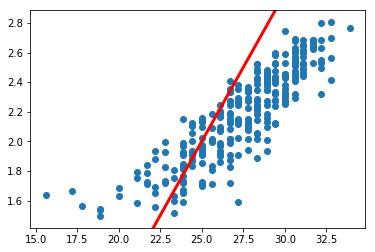

In [15]:
plot_reg_line(data_summer.temp, data_summer.demand, 0.2, -3)

### Esercizio

- Implementare la funzione abbozzata sotto in modo che esegua la discesa gradiente per un numero _N_ di iterazioni e restituisca la tupla dei parametri `(alpha, beta)` dopo aver mostrato un grafico col modello ottenuto
  - riutilizzare le due funzioni illustrate sopra

In [16]:
def plot_uni_lin_reg_gd(X, Y, N):
    alpha, beta = uni_lin_reg_gd(X, Y, N)
    plot_reg_line(X, Y, alpha, beta)
    return alpha, beta

### Progressione della Discesa Gradiente

- Usiamo la funzione per visualizzare la progressione del modello attraverso le iterazioni della discesa gradiente
- La retta del modello iniziale $\alpha=0,\beta=0$ è fuori dall'area del grafico...

(0, 0)

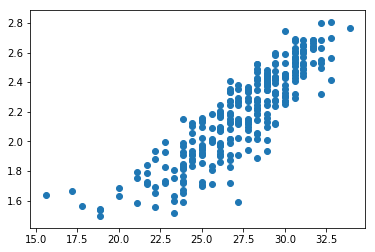

In [17]:
plot_uni_lin_reg_gd(data_summer.temp, data_summer.demand, 0)

Dopo una iterazione...

(0.12111570253623187, 0.0043684136956521746)

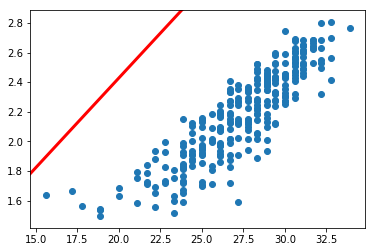

In [18]:
plot_uni_lin_reg_gd(data_summer.temp, data_summer.demand, 1)

Dopo 2 iterazioni...

(0.05857258988807923, 0.0021065722352546744)

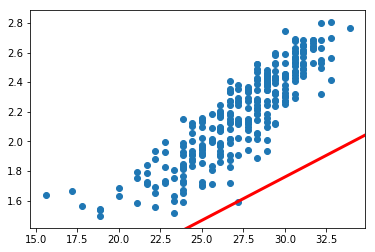

In [19]:
plot_uni_lin_reg_gd(data_summer.temp, data_summer.demand, 2)

Dopo 3 iterazioni...

(0.09086964787114596, 0.003268549875787045)

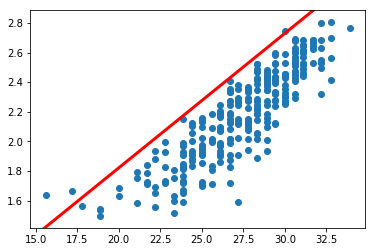

In [20]:
plot_uni_lin_reg_gd(data_summer.temp, data_summer.demand, 3)

Dopo 4 iterazioni...

(0.0741918828492701, 0.0026624906359728057)

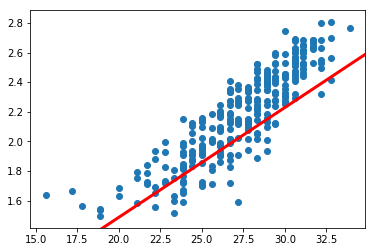

In [21]:
plot_uni_lin_reg_gd(data_summer.temp, data_summer.demand, 4)

Dopo 5 iterazioni...

(0.08280438535410464, 0.0029694338478559097)

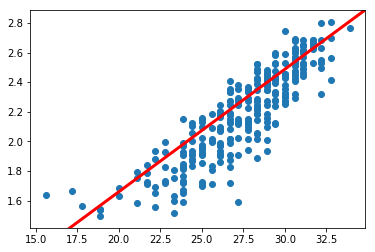

In [22]:
plot_uni_lin_reg_gd(data_summer.temp, data_summer.demand, 5)

Dopo 10 iterazioni...

(0.07976455089011326, 0.0028398135671445297)

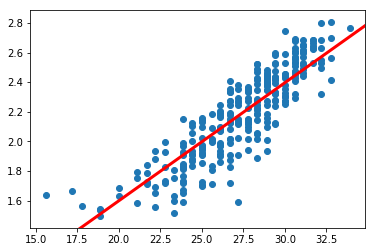

In [23]:
plot_uni_lin_reg_gd(data_summer.temp, data_summer.demand, 10)

Dopo 100 iterazioni...

(0.07988513044679865, 0.002486784326229603)

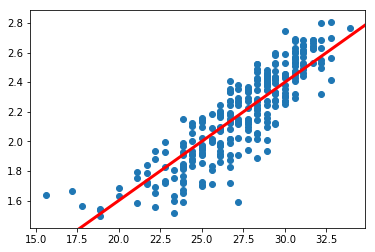

In [24]:
plot_uni_lin_reg_gd(data_summer.temp, data_summer.demand, 100)

## Andamento dell'Errore

- Durante la discesa gradiente l'errore compiuto dal modello si riduce progressivamente
- Prendiamo ad esempio i parametri del modello addestrato con 5 iterazioni...

In [25]:
alpha, beta = uni_lin_reg_gd(data_summer.temp, data_summer.demand, 5)

### Esercizio

- Implementare la funzione `mse` che, dati in input
  - il vettore `x` con $m$ osservazioni della variabile indipendente
  - il vettore `y` con le corrispondenti osservazioni della variabile dipendente
  - i valori dei parametri $\alpha$ e $\beta$
- calcoli l'errore quadratico medio secondo la formula
$$ \mathrm{MSE}=\frac{1}{m}\sum_{j=1}^m\left(\alpha\cdot x_j+\beta-y_j\right)^2 $$

In [26]:
def mse(x, y, alpha, beta):
    return ((alpha * x + beta - y) ** 2).mean()

- Usiamo la funzione appena creata per calcolare l'errore del modello con 5 iterazioni

In [27]:
mse(data_summer.temp, data_summer.demand, alpha, beta)

0.0288456492124837

- Se calcoliamo l'errore ad un numero di iterazioni superiore, es. 50, otteniamo un risultato inferiore

In [28]:
alpha, beta = uni_lin_reg_gd(data_summer.temp, data_summer.demand, 50)
mse(data_summer.temp, data_summer.demand, alpha, beta)

0.022314699238245188

### Grafico dell'Errore

- Possiamo visualizzare l'andamento dell'errore attraverso le iterazioni
- Calcoliamo l'errore per qualsiasi numero di iterazioni da 0 a 20 e inseriamo i valori in un vettore

In [29]:
mse_progression = np.array([mse(data_summer.temp, data_summer.demand, *uni_lin_reg_gd(data_summer.temp, data_summer.demand, N))
                            for N in range(21)])

_(questo metodo è inefficiente in quanto la discesa gradiente è rieseguita da capo per ogni numero N di iterazioni, un'implementazione più efficiente è lasciata come esercizio opzionale)_

In [30]:
mse_progression

array([4.8654182 , 1.31378682, 0.36670176, 0.11415017, 0.04680426,
       0.02884565, 0.02405676, 0.02277973, 0.02243919, 0.02234837,
       0.02232414, 0.02231766, 0.02231592, 0.02231545, 0.02231531,
       0.02231526, 0.02231524, 0.02231522, 0.0223152 , 0.02231519,
       0.02231517])

- Creiamo quindi un grafico a linea col numero di iterazioni sull'asse X e l'errore corrispondente sull'asse Y
  - `plot` assume di default come valori X i numeri interi da 0, possiamo quindi specificare solo le Y

Text(0,0.5,'Mean squared error')

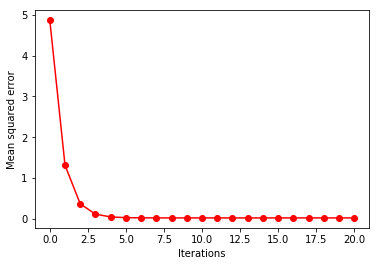

In [31]:
plt.plot(mse_progression, "ro-")
# "ro-" = rosso, pallini, tratto continuo
plt.xlabel("Iterations")
plt.ylabel("Mean squared error")

- Vediamo come l'errore raggiunga un minimo dopo poche iterazioni

- Per visualizzare meglio l'andamento per valori piccoli, applichiamo una scala logaritmica all'asse Y
  - per farlo usiamo `semilogy` al posto di `plot`

Text(0,0.5,'Mean squared error')

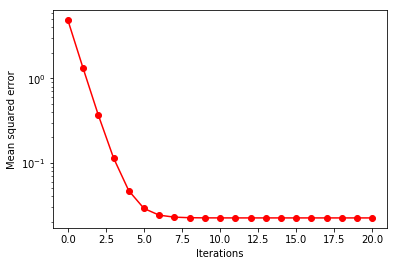

In [32]:
plt.semilogy(mse_progression, "ro-")
plt.xlabel("Iterations")
plt.ylabel("Mean squared error")

## Esercizio: Analisi dei Mesi Invernali

- Finora abbiamo svolto l'analisi sui mesi estivi, imputando una parte consistente di consumo di elettricità all'aria condizionata
- Analogamente, ipotizziamo che nei mesi invernali una quota importante di elettricità sia consumata per il riscaldamento (es. stufe elettriche) in modo dipendente dalla temperatura
- Estraiamo questa volta i dati relativi ai mesi di dicembre, gennaio e febbraio

In [33]:
data_winter = data.loc[data.date.dt.month.isin([12, 1, 2])]

Riutilizzando opportunamente le funzioni definite sopra:
1. visualizzare i dati in un grafico a dispersione
2. addestrare un modello di regressione con 3000 iterazioni di discesa gradiente
3. visualizzare il modello estratto nel grafico del punto 1
4. usando il modello, prevedere il picco di consumo che si avrà con una temperatura di -5 °C

### Soluzioni

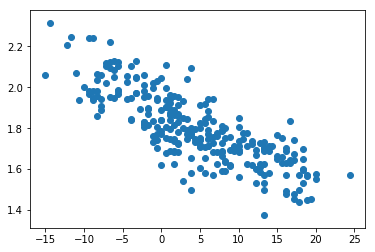

In [34]:
plt.scatter(data_winter.temp, data_winter.demand)

In [35]:
alpha, beta = uni_lin_reg_gd(data_winter.temp, data_winter.demand, 3000)

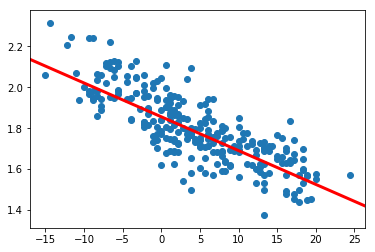

In [36]:
plot_reg_line(data_winter.temp, data_winter.demand, alpha, beta)

In [37]:
alpha * (-5) + beta

1.9382952328991991

## Caso di Studio 2: Predizione Valori delle Case nei Quartieri

- Un'agenzia immobiliare deve determinare i prezzi delle case in vendita
- Un aspetto importante per determinare il prezzo è il quartiere in cui la casa si trova
- Per ogni quartiere si possono individuare delle caratteristiche sommarie
  - dati demografici, posizione, tasse, criminalità, ...
- In base a queste caratteristiche, si vuole determinare il prezzo ideale dell'abitazione "media" di qualsiasi quartiere

## Dati d'Esempio

- Il dataset _Housing_, usato in ricerca e disponibile sul Web, contiene informazioni sui quartieri residenziali di Boston
- I dati possono essere reperiti al seguente URL:

In [38]:
housing_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"

- I dati sono disposti in colonne di larghezza fissa, separate con spazi, senza una riga di intestazione
```
 0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00
 0.02731   0.00   7.070  0  0.4690  6.4210  78.90  4.9671   2  242.0  17.80 396.90   9.14  21.60
 0.02729   0.00   7.070  0  0.4690  7.1850  61.10  4.9671   2  242.0  17.80 392.83   4.03  34.70
...
```
- Possiamo considerarlo come un CSV dove è usato un numero variabile di spazi come separatore
  - usiamo l'espressione regolare "`\s+`" che indica "uno o più spazi"

In [39]:
data = pd.read_csv(housing_url, header=None, sep="\s+")

- Quante righe e colonne contiene il file importato?

In [40]:
data.shape

(506, 14)

- Non essendoci una riga di header, dobbiamo impostare manualmente i nomi delle colonne

In [41]:
data.columns = "CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT MEDV".split()

In [42]:
data.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


### Lista delle variabili

- CRIM: tasso di criminalità pro capite per zona
- ZN: proporzione terreno residenziale per lotti maggiori di 25.000 piedi quadrati (circa 2300 m2)
- INDUS: proporzione di acri industriali non commerciali per città
- CHAS: variabile fittizia Charles River, 1 se il tratto affianca il fiume, altrimenti 0
- NOX: concentrazione di ossido d’azoto (parti per 10 milioni)
- RM: numero medio di stanze per abitazione
- AGE: proporzione delle unità abitate costruite prima del 1940
- DIS: distanze pesate verso i cinque uffici di collocamento di Boston
- RAD: indice di accessibilità rispetto alle grandi vie radiali di comunicazione
- TAX: tasso di imposte sulla casa per 10.000 dollari
- PTRATIO: rapporto allievi-docenti per città
- B: 1000(Bk - 0.63)2, dove Bk è la proporzione di persone di origine afroamericana
- LSTAT: percentuale di popolazione con basso reddito
- **MEDV: valore mediano delle abitazioni di proprietà in migliaia di dollari**
  - vogliamo stimare il valore di questa variabile in funzione delle altre

## Regressione Lineare Multivariata

- Nella regressione multivariata una variabile dipendente è stimata su $n$ variabili indipendenti
- Il modello è rappresentabile come un iperpiano in $n+1$ dimensioni con $n+1$ parametri ($n$ coefficienti angolari più l'intercetta)
$$ h(\mathbf{x})=\theta_0+\sum_{i=1}^n\theta_i\cdot x_i=\mathbf{\theta}\cdot([1]\Vert\mathbf{x}) $$
- Un insieme di $m$ osservazioni su cui addestrare il modello può essere rappresentato da
  - una matrice $\mathbf{X}$ con $m\times n$ valori delle variabili indipendenti
  - un vettore $\mathbf{y}$ con i corrispondenti $m$ valori noti della variabile dipendente

## Dati per la Regressione

- Dobbiamo estrarre dai dati caricati la matrice **X** e il vettore **y**
- **y** è dato dalla colonna `MEDV` del frame
  - con `values` si estrae l'array dei valori contenuti in una serie o frame

In [43]:
y = data["MEDV"]

- **X** è dato dall'intero frame ad esclusione della colonna `MEDV`
  - usiamo il metodo `drop` per ottenere una copia del frame senza la colonna

In [44]:
X = data.drop(columns=["MEDV"])

## Algoritmo di Discesa del Gradiente

- Vediamo l'implementazione della discesa del gradiente per la regressione lineare multivariata

In [45]:
def lin_reg_gd(X, y, N=50, step_size=0.000001):
    # estraggo numero di osservazioni e di feature
    m, n = X.shape
    # creo copia di X con aggiunta una colonna di 1
    # (hstack concatena matrici orizzontalmente)
    X1 = np.hstack([np.ones((m, 1)), X])
    # inizializzo vettore parametri a zero
    theta = np.zeros(n+1)
    for it in range(N):
        # calcolo l'errore su ciascuna osservazione
        error = X1.dot(theta) - y
        # calcolo il gradiente
        grad = 2 / m * (X1.T.dot(error))
        # aggiorno il vettore dei parametri
        theta -= step_size * grad
    return theta

## Addestramento Modello e Predizione

- Eseguendo la funzione, otteniamo un vettore di parametri del modello

In [46]:
theta = lin_reg_gd(X, y)

- Dato un vettore di valori delle variabili indipendenti, ad es. la prima riga di **X**...

In [47]:
sample = X.iloc[0]

- ...possiamo calcolare il valore di _y_ predetto così

In [48]:
theta[0] + theta[1:].dot(sample)

23.986402721555702

- Per confronto, il valore reale è

In [49]:
y[0]

24.0

## Funzione d'Errore

- L'errore quadratico medio di cui è stato usato il gradiente sopra è calcolato come

$$ E(\mathbf\theta)=\frac{1}{m}\sum_{j=1}^m\left(\mathbf\theta\cdot\left([1]\Vert\mathbf{x}_j\right)-y_j\right)^2 $$

In [50]:
def mse(X, y, theta):
    m, n = X.shape
    X1 = np.hstack([np.ones((m, 1)), X])
    return ((X1.dot(theta) - y) ** 2).mean()

- Come sopra, possiamo verificare l'andamento dell'errore in base al numero di iterazioni

In [51]:
error_prog = np.array([mse(X, y, lin_reg_gd(X, y, N)) for N in range(21)])

In [52]:
error_prog

array([592.146917  , 196.2463961 , 136.88296511, 124.94882794,
       119.97921125, 116.28477969, 113.04227934, 110.11150159,
       107.45005962, 105.03133491, 102.8328108 , 100.83426711,
        99.01736971,  97.36546963,  95.86344477,  94.49755929,
        93.25533651,  92.12544348,  91.09758609,  90.16241388,
        89.31143353])

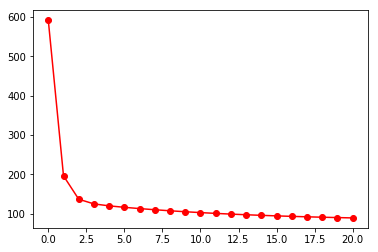

In [53]:
plt.plot(error_prog, "ro-")

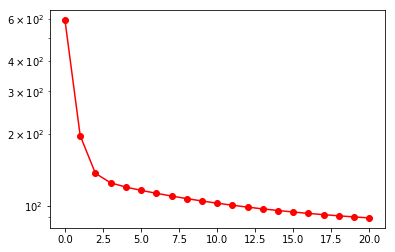

In [54]:
plt.semilogy(error_prog, "ro-")

## scikit-learn

- Invece di implementare manualmente l'addestramento e l'uso di modelli, vediamo come usare una libreria apposita...
- _scikit-learn_ offre diversi algoritmi e funzioni di supporto per l'addestramento di modelli predittivi, inclusa la regressione lineare
  - tutti i tipi di modelli offrono un'interfaccia comune per l'addestramento e la predizione (_inferenza_)
  - i dati in ingresso sono rappresentati come array NumPy o serie/frame pandas

In [55]:
import sklearn

## Divisione in Training e Validation Set

- Dall'analisi di regressione dobbiamo ottenere un modello generale, che dia stime affidabili anche su dati simili ma non identici a quelli su cui è costruito
- Per questo è necessario valutare come si comporta il modello su dati diversi da quelli di addestramento
- È comune dividere i dati a disposizione per costruire il modello in
  - un _training set_ su cui il modello è effettivamente addestrato, minimizzando l'errore su di esso
  - un _validation set_ su cui verificare l'errore del modello
- scikit-learn offre una funzione `train_test_split` per dividere casualmente un set di dati in due parti disgiunte

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.3, random_state=44)

## Addestramento di un Modello

- Per addestrare un modello di regressione con scikit-learn, dapprima creiamo un oggetto modello "vuoto"

In [57]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()

- Quindi usiamo il metodo `fit` per addestrarlo sui dati del training set

In [58]:
lrm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Parametri del Modello

- Dal modello addestrato possiamo consultarne i parametri: i coefficienti angolari e l'intercetta

In [59]:
lrm.coef_

array([-1.04665683e-01,  5.86209331e-02, -5.05429305e-04,  2.51348609e+00,
       -2.08012904e+01,  3.13959777e+00,  4.85560551e-03, -1.78869240e+00,
        2.98933987e-01, -1.16491699e-02, -9.96953430e-01,  1.06185800e-02,
       -5.28177921e-01])

In [60]:
lrm.intercept_

43.47797322841991

- Possiamo associare ad ogni coefficiente angolare il nome della variabile corrispondente, per capire quali fenomeni influiscano positivamente e negativamente

In [61]:
pd.Series(lrm.coef_, index=X.columns)

CRIM       -0.104666
ZN          0.058621
INDUS      -0.000505
CHAS        2.513486
NOX       -20.801290
RM          3.139598
AGE         0.004856
DIS        -1.788692
RAD         0.298934
TAX        -0.011649
PTRATIO    -0.996953
B           0.010619
LSTAT      -0.528178
dtype: float64

- Vediamo ad esempio che il modello prevede il valore mediano delle abitazioni:
  - più alto di circa 2.500 dollari nei quartieri vicini al fiume (variabile CHAS)
  - circa 3.140 dollari più alto per ciascuna stanza (variabile RM)

## Ottenere Predizioni dal Modello

- Col metodo `predict`, dato un set di osservazioni delle variabili indipendenti, possiamo ottenere i corrispondenti valori della variabile dipendente previsti dal modello
- Ad esempio, passando la matrice `X_train`, otteniamo i valori di _y_ previsti dal modello per le osservazioni di training, che saranno un'approssimazione dei valori reali

In [62]:
pred_train = lrm.predict(X_train)

In [63]:
pred_train[:5]

array([26.36282482, 12.79041347, 33.24809334, 36.876313  , 22.76510566])

- Otteniamo allo stesso modo anche le predizioni relative al validation set

In [64]:
pred_val = lrm.predict(X_val)

## Calcolo dell'Errore del Modello

- Confrontando le risposte date dal modello con i dati effettivi, possiamo quantificare l'errore compiuto dal modello sui dati
- Ad esempio possiamo calcolare l'errore quadratico medio sui dati di training, che è stato minimizzato dal modello

In [65]:
((pred_train - y_train)**2).mean()

22.513359512263296

### Esercizi

1. Calcolare l'errore quadratico medio sul validation set
2. Definendo l'_errore relativo_ tra valore reale $y$ e predetto $\hat{y}$ come $\left|\frac{\hat{y}-y}{y}\right|$, calcolare l'errore relativo medio su training e validation set

In [66]:
((pred_val - y_val)**2).mean()

21.4391495236496

In [67]:
((pred_train - y_train) / y_train).abs().mean()

0.16420859067207838

In [68]:
((pred_val - y_val) / y_val).abs().mean()

0.1665218243695783

## Caso di Studio 3: Stima Polarità delle Recensioni

- Sul Web si trovano molte opinioni scritte dagli utenti di prodotti e servizi
- Alcune di queste sono etichettate con voti in una scala numerica (es. da 1 a 5 stelle)
- Estraendo conoscenza da queste, vogliamo estrarre un modello che classifichi come positive o negative le opinioni senza un voto indicato esplicitamente
- Per capire in modo semplice l'orientamento di un testo possiamo cercare in esso delle parole chiave che denotino un parere positivo o negativo

## Recensioni

- Abbiamo un insieme di 10.000 recensioni di film tratte da Amazon, etichettate con voti da 1 a 5 stelle
- Sono contenute nel file CSV compresso `reviews.csv.gz`, con due colonne "text" e "stars"
- Come al solito usiamo pandas per leggere il file da URL, specificando
  - che il carattere di tabulazione è usato come separatore
  - il tipo di compressione usata dal file

In [69]:
reviews = pd.read_csv("https://git.io/vpaDt", sep="\t", compression="gzip")

### Visualizzare i Dati Caricati

- Visualizziamo una porzione dei dati caricati
  - per visualizzare meglio i dati, aumentiamo prima il numero di caratteri massimo per colonna

In [70]:
pd.options.display.max_colwidth = 100

In [71]:
reviews.head(5)

,text,stars
0,George Romero did the right thing when he picked Tom Savini to remake Night of The Living Dead. ...,5
1,"OK, that makes it sound like something out of an old Buck Roger's serial. Yet, this spoof of ev...",5
2,"- At a tribal village, a pensive Elizabeth Curtis to her brother while Quatermain haggles with t...",5
3,"Wow! This has to be one of the more unusual movies I've ever seen, one that is leaves you shakin...",5
4,Kevin Costner is one of those actors that I never quite know what to expect from his movies. He'...,5


- Come sono distribuiti i voti?

In [72]:
reviews.stars.value_counts()

5    4708
4    2620
3    1434
2     704
1     534
Name: stars, dtype: int64

## Liste di Parole Positive e Negative

- Esistono sul Web diverse basi di conoscenza in grado di fornire indicazioni su quali parole siano positive o negative
- In questo esempio usiamo l'_Opinion Lexicon_ di Hu & Liu, costituito da un totale di circa 6.800 parole
  - Minqing Hu and Bing Liu. "Mining and summarizing customer reviews." Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, 2004.
- I file con le parole positive e negative si possono trovare ai seguenti URL:

In [73]:
pos_words_url = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/positive-words.txt"
neg_words_url = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/negative-words.txt"

- Definiamo una funzione per estrarre le parole dai file, eliminando righe vuote e commenti

In [74]:
def get_opinion_words(url):
    from urllib.request import urlopen
    words = set()
    for line in urlopen(url):            # leggi righe in stringhe di byte
        try:
            line = line.decode().strip() # converti in testo e rimuovi a capo
        except UnicodeDecodeError:
            continue                     # caratteri sconosciuti -> salta riga
        if line and line[0] != ";":      # escludi righe vuote e commenti ";"
            words.add(line)
    return words

Usiamo la funzione per importare le liste di parole

In [75]:
pos_words = get_opinion_words(pos_words_url)   # 2.006 parole
neg_words = get_opinion_words(neg_words_url)   # 4.782 parole

### Esempi di Parole Positive e Negative

In [76]:
sorted(pos_words)[:10]

['a+',
 'abound',
 'abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible',
 'acclaim',
 'acclaimed',
 'acclamation']

In [77]:
sorted(neg_words)[:10]

['2-faced',
 '2-faces',
 'abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate',
 'abomination',
 'abort',
 'aborted']

## Estrazione delle Singole Parole dai Testi

- Per ricercare agevolmente le parole chiave nelle recensioni, convertiamo per ciascuna il testo completo in una lista delle parole contenute
- Sulle serie di tipo testuale possiamo usare l'attributo `str` per eseguire operazioni in batch su ciascun valore (simile a `dt` visto sopra per date/ore)
- Convertiamo i testi delle recensioni in minuscolo ed estraiamo liste delle singole parole
  - queste sono operazioni basilari di preprocessamento di dati testuali, che approfondiremo in una lezione apposita

In [78]:
reviews["tokens"] = reviews.text.str.lower().str.split(r"\W+")

In [79]:
reviews[["tokens"]].head(3)

,tokens
0,"[george, romero, did, the, right, thing, when, he, picked, tom, savini, to, remake, night, of, t..."
1,"[ok, that, makes, it, sound, like, something, out, of, an, old, buck, roger, s, serial, yet, thi..."
2,"[, at, a, tribal, village, a, pensive, elizabeth, curtis, to, her, brother, while, quatermain, h..."


## Conteggi Parole

- Col metodo `map`, possiamo applicare una funzione arbitraria a ciascun elemento di una serie
- Possiamo ad esempio ottenere il numero totale di parole di ciascuna recensione applicando la funzione `len` a ciascuna lista di parole

In [80]:
reviews["tot_words"] = reviews.tokens.map(len)

- Al posto di una funzione, si può utilizzare un'espressione lambda
- Utilizziamole ad esempio per ottenere i conteggi di parole positive e negative per ogni recensione

In [81]:
reviews["pos_words"] = reviews.tokens.map(lambda l: sum(1 for w in l if w in pos_words))
reviews["neg_words"] = reviews.tokens.map(lambda l: sum(1 for w in l if w in neg_words))

- Aggiungiamo anche la differenza tra queste ultime due quantità

In [82]:
reviews["words_diff"] = reviews.pos_words - reviews.neg_words

- Con le nuove colonne il DataFrame risulta così... (omettiamo le colonne "text" e "tokens" per brevità)

In [83]:
reviews.drop(columns=["text", "tokens"]).head()

,stars,tot_words,pos_words,neg_words,words_diff
0,5,229,15,4,11
1,5,234,7,5,2
2,5,637,22,25,-3
3,5,204,14,6,8
4,5,835,37,39,-2


## Etichettatura Recensioni come Positive o Negative

- Piuttosto che prevedere il numero esatto di stelle di una recensione, siamo interessati a distinguere tra _positive_ e _negative_
- Determiniamo empiricamente che le recensioni con 4 o 5 stelle siano etichettate come `pos`, mentre quelle con 3 o meno come `neg`
- Per le predizioni del modello, consideriamo 3.5 come soglia tra `pos` e `neg`
- Definiamo una funzione che converta una sequenza di valori in stelle in una di etichette `pos` e `neg`

In [84]:
def stars_to_label(stars):
    # np.where(X, a, b) converte tutti i True di X ad a e tutti i False a b
    return np.where(stars >= 3.5, "pos", "neg")

- Usiamo la funzione per aggiungere una colonna "label" al dataset

In [85]:
reviews["label"] = stars_to_label(reviews.stars)

In [86]:
reviews.label.value_counts()

pos    7328
neg    2672
Name: label, dtype: int64

## Divisione in Training e Validation Set

- Eseguiamo la divisione tra training e validation set come segue

In [87]:
reviews_train, reviews_val = train_test_split(reviews, test_size=0.3, random_state=42)

## Esercizi

1. Visualizzare un grafico a dispersione delle recensioni con la variabile `words_diff` sull'asse X e il numero di stelle sull'asse Y
2. Addestrare sul training set un modello univariato per la predizione del numero di stelle basandosi sulla sola variabile `words_diff`
3. Calcolare sul validation set l'accuratezza del modello, intesa come percentuale di recensioni classificate correttamente come "pos" o "neg"
4. Addestrare un modello multivariato direttamente sui numeri `pos_words` e `neg_words` di parole positive e negative e calcolarne l'accuratezza come sopra
5. Calcolare il numero minimo di parole negative che una recensione senza parole positive dovrebbe contenere per essere considerata negativa dal modello
6. Aggiungere al dataset originale delle colonne `pos_rate` e `neg_rate` con i numeri di parole positive e negative divisi per il totale e ripetere la divisione del dataset in training e validation
7. Usando questi due set aggiornati, addestrare un modello sulle due nuove variabili e calcolarne l'accuratezza come sopra
8. Creare una copia dei dati in cui sono rimosse le recensioni "neutre" la cui differenza tra parole positive e negative è compresa tra -2 e 2
9. Dividere il nuovo dataset in training e validation set e ripetere i punti dall'1 al 7 su questi nuovi dati (tranne il 6 che sarà già fatto)

## Soluzioni

### 1. Grafico di dispersione

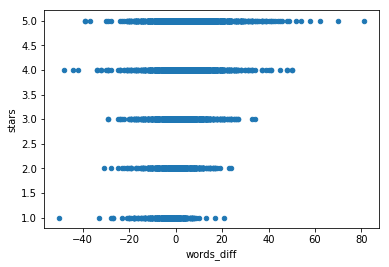

In [88]:
reviews.plot.scatter("words_diff", "stars")

### 2. Addestramento modello

In [89]:
# creo il modello
lrm_diff = LinearRegression()
# lo addestro sulla sola colonna words_diff
lrm_diff.fit(reviews_train[["words_diff"]], reviews_train["stars"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### 3. Calcolo accuratezza

In [90]:
# ottengo le predizioni come numero di stelle
diff_preds = lrm_diff.predict(reviews_val[["words_diff"]])
# converto da numero di stelle a etichette pos/neg
diff_pred_labels = stars_to_label(diff_preds)
# verifico quali etichette predette combacino con quelle reali
diff_hits = diff_pred_labels == reviews_val.label
# calcolo la percentuale di successi
diff_hits.mean()

0.7293333333333333

In [91]:
# per i prossimi punti, definisco una funzione parametrizzabile su dati e modello
def accuracy(data, labels, model):
    preds = model.predict(data)
    pred_labels = stars_to_label(preds)
    hits = pred_labels == labels
    return hits.mean()

In [92]:
accuracy(reviews_val[["words_diff"]], reviews_val.label, lrm_diff)

0.7293333333333333

### 4. Modello sui due conteggi di parole

In [93]:
# per brevità, salvo la lista delle colonne usate in una costante
count_cols = ["pos_words", "neg_words"]
lrm_count = LinearRegression()
lrm_count.fit(reviews_train[count_cols], reviews_train["stars"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [94]:
accuracy(reviews_val[count_cols], reviews_val.label, lrm_count)

0.729

### 5. Limite di parole negative

Siano $\theta_n<0$ e $\theta_0>0$ il coefficiente di `neg_words` e l'intercetta, per trovare il numero minimo $x$ di parole negative dobbiamo risolvere:

$$ \theta_n\cdot x+\theta_0 < 3.5 \Rightarrow x > \frac{3.5-\theta_0}{\theta_n} $$

In [95]:
(3.5 - lrm_count.intercept_) / lrm_count.coef_[1]

11.164807243861542

### 6. Aggiunta dei conteggi relativi

In [96]:
reviews["pos_rate"] = reviews.pos_words / reviews.tot_words
reviews["neg_rate"] = reviews.neg_words / reviews.tot_words
reviews_train, reviews_val = train_test_split(reviews, test_size=0.3, random_state=42)

### 7. Modello sui conteggi relativi

In [97]:
rate_cols = ["pos_rate", "neg_rate"]
lrm_rate = LinearRegression()
lrm_rate.fit(reviews_train[rate_cols], reviews_train.stars)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [98]:
accuracy(reviews_val[rate_cols], reviews_val.label, lrm_rate)

0.742

### 8. Rimozione delle recensioni neutre

In [99]:
reviews_filt = reviews[~reviews.words_diff.between(-2, 2)]

In [100]:
# quante recensioni rimangono?
len(reviews_filt)

6735

### 9. Divisione dei dati e rivalutazione dei modelli

In [101]:
reviews_filt_train, reviews_filt_val = train_test_split(reviews_filt, test_size=0.3, random_state=42)

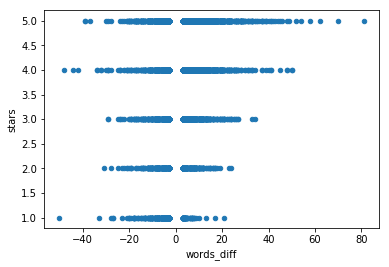

In [102]:
reviews_filt.plot.scatter("words_diff", "stars")

**Modello su differenza**

In [103]:
lrm_diff_filt = LinearRegression()
lrm_diff_filt.fit(reviews_filt_train[["words_diff"]], reviews_filt_train.stars)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [104]:
accuracy(reviews_filt_val[["words_diff"]], reviews_filt_val.label, lrm_diff_filt)

0.7659574468085106

**Modello su conteggi**

In [105]:
lrm_count_filt = LinearRegression()
lrm_count_filt.fit(reviews_filt_train[count_cols], reviews_filt_train.stars)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [106]:
accuracy(reviews_filt_val[count_cols], reviews_filt_val.label, lrm_count_filt)

0.7615042058386937

In [107]:
(3.5 - lrm_count_filt.intercept_) / lrm_count_filt.coef_[1]

12.253991451027714

**Modello su conteggi relativi**

In [108]:
lrm_rate_filt = LinearRegression()
lrm_rate_filt.fit(reviews_filt_train[rate_cols], reviews_filt_train.stars)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [109]:
accuracy(reviews_filt_val[rate_cols], reviews_filt_val.label, lrm_rate_filt)

0.7694210786739238